<a href="https://colab.research.google.com/github/xKDR/Julia-Workshop/blob/main/SatelliteImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IF YOU HAVE RECIEVED THIS. PLEASE DON'T SHARE IT.

It contains my key, and there is a download limit on it.

<center>
<h1> Exploring economic activity from outer space: A Julia notebook for processing and analyzing satellite nighttime lights </h1>
<h3> Ayush Patnaik </h3>

</center>



**License:** Copyright (c) 2024 Ayush Patnaik. This work is licensed under a Creative Commons Attribution 4.0 International License.

<center>
<h1> Abstract </h1>

</center>

This notebook demonstrates the processing of nighttime lights data to analyze urbanization and economic activity. Using the Julia programming language and various geospatial data processing packages, the notebook outlines methods for handling nighttime lights data, including installation of necessary software, data downloading and preparation, and techniques such as cropping, masking, and overlaying vector files on raster data. The study employs a datacube approach to visualize and quantify changes in light intensity over time. The Delhi region in India is used as an example to showcase these methods.

# 1 Introduction

Nighttime lights (NTL) data have become a widely recognized proxy for monitoring economic activity at various levels, including national, subnational, and supranational (Chen & Nordhaus, 2011; Henderson et al., 2012; Sutton et al., 2007). NTL data offer significant advantages over traditional economic indicators like GDP, such as greater spatial granularity, timeliness, and lower cost. Moreover, NTL data are comparable across different regions, irrespective of variations in statistical capacity, political interference, or informal activities.

NTL data can be used to analyze the impact of localized policies (Kim et al., 2024). They provide valuable insights into economic performance and development at the subnational level, particularly in regions where reliable data are scarce (Gibson et al., 2020; Zheng et al., 2023).

Despite their potential benefits, recent NTL data products (Elvidge et al., 2017, 2021; Li et al., 2020; Román et al., 2018) have seen limited use. One reason is the lack of accessible methods for processing and analyzing satellite images. Another is the need for an efficient framework to handle large data volumes. To address these issues, we introduce a geocomputational notebook that provides a step-by-step guide to processing and analyzing recent satellite NTL images. This notebook uses Julia for efficient data processing, leveraging its performance capabilities for handling extensive datasets.

Accessing, processing, and analyzing satellite data require a basic understanding of remote sensing and programming principles. To lower the learning curve and promote the use of these data, many researchers have shared their data processing routines as libraries or functions across various programming languages. For example, Falchetta (2023), Miethe (2023), and Njuguna (2020) have developed R libraries for extracting data from nightlight satellite imagery. Raschky (2020) has provided Python functions for the same purpose. Patnaik et al. (2023) have assembled a Julia library for processing nightlight imagery. Patnaik & Mendez (2024) introduced a Jupyter notebook hosted in a cloud-based environment to enhance accessibility by leveraging the pedagogical and computational features of Jupyter notebooks (Rowe et al., 2020; Reades, 2020; Chen et al., 2020). This notebook builds upon  Patnaik & Mendez (2024) providing an efficient alternative.

This notebook is arranged as follows. In section 1, we install Julia on our Colab notebook, and check the installation. In section 2, we install and import the packages. In section 3, we download the V2.1 annual nighttime lights data using the Earth Observation Group's API. Additionally, we define a function to lead the image of a give year. In section 4, we download vector file containing polygons of states of India. We and demonstrate some basic processes combining raster data with vector data. This include cropping, masking, zonal statistics, etc. In section, we demonstrate some alternative ways of cropping and masking. Finally, in section 6, we demonstrate the true prowess of Julia, stacking images of different years, turning them into a datacube, and processing images multiple years together.


# 2 Cloud-based environment

Modern computational notebooks integrate code with descriptive text, equations, visualizations, and tables, enhancing the reproducibility and transparency of scientific research (Rowe et al., 2020). However, ensuring a consistent computational environment remains challenging, especially for geospatial analysis, as users must manage multiple libraries and dependencies. Cloud-based environments like Google Colab, Anaconda Cloud, and Deepnote address this by providing reproducible setups with a single click. Our notebook, hosted on Google Colab, offers a fully reproducible environment for processing and analyzing satellite images, easily duplicable and extendable with a Google account.

By default, Google Colab only support Python. We download Julia 1.10.4 and install it in the first cell.

Run the first cell, **then reload the page**. In most computers, the shortcut is Ctrl + R. Your browswer may ask if you want to leave this page. Say yes.
Julia 1.10.4 will be installed, and you should be able to run the notebook.

In [1]:
# @title 2.1 Download and install Julia

%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.4"
JULIA_PACKAGES="IJulia"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

## This code block is taken from https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb#scrollTo=2UMidUQB03vJ

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


**Please ignore:** "Unrecognized magic %%shell."

In [2]:
# @title 2.2 Verify installation

versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


The `versioninfo()` function prints Julia version and other info about the system.

## 2.3 Install and import packages

At its minimum, this environment requires the packages shown in Table 1.

| Package Name  | Version | Description |
|---------------|---------|-------------|
| Rasters       | 0.11    | Tools for working with raster spatial data formats (GeoTIFF, NetCDF, etc.). |
| HTTP          | 1.10    | Facilitates making HTTP requests to download data from the web. |
| JSON          | 0.21    | Enables parsing and working with JSON data structures. |
| Glob          | 1.3     | Offers functions for finding files based on patterns (wildcards). |
| ArchGDAL      | 0.10.4  | Provides an interface to the GDAL library for Geospatial Data Abstraction Layer functionality. |
| DataFrames    | 1.6.1   | Tools for working with data frames (tabular data structure) in Julia. |
| Statistics    | 0.10.4  | Collection of functions for statistical analysis and data manipulation. |
| GeoJSON       | 0.8.1   | Allows working with GeoJSON format, a common way to represent geographic features. |
| Plots         | 1.40    | Offers functions for creating various graphical visualizations (scatter plots, bar charts, etc.). |
| CubicSplines  | 0.1     | Provides tools for cubic spline interpolation and fitting. |


**Table 1:**  List of required packages

We install these packages in the following cell.

In [3]:
# @title Use Pkg to add the packages

using Pkg

Pkg.add([
    PackageSpec(name="Rasters", version="0.11"),
    PackageSpec(name="HTTP", version="1.10"),
    PackageSpec(name="JSON", version="0.21"),
    PackageSpec(name="Glob", version="1.3"),
    PackageSpec(name="ArchGDAL", version="0.10.4"),
    PackageSpec(name="DataFrames", version="1.6.1"),
    PackageSpec(name="Statistics", version="0.10.4"),
    PackageSpec(name="GeoJSON", version="0.8.1"),
    PackageSpec(name="Plots", version="1.40"),
    PackageSpec(name="CubicSplines", version="0.2")
])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JpegTurbo_jll ──────────────── v3.0.4+0
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed Libmount_jll ───────────────── v2.40.2+0
   Installed LRUCache ───────────────────── v1.6.1
   Installed OffsetArrays ───────────────── v1.14.1
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.3+0
   Installed GDAL_jll ───────────────────── v301.1000.0+0
   Installed Opus_jll ───────────────────── v1.3.3+0
   Installed LERC_jll ───────────────────── v4.0.0+0
   Installed LoggingExtras ──────────────── v1.1.0
   Installed GR_jll ─────────────────────── v0.73.8+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed DimensionalData ────────────── v0.27.9
   Installed ColorSchemes ───────────────── v3.27.1
   Installed ConcurrentUtilities ────────── v2.4.2
   Install

In [4]:
# @title Import the packages

using GeoJSON, Rasters, Plots, Statistics, DataFrames, Dates, Glob, Base.Filesystem, HTTP, JSON, ArchGDAL, CubicSplines

# 3 Data

In this notebook, we use three datasets: (1) satellite nighttime light images from Elvidge et al. (2021)

Note: While minimal adjustments enable the use of images of 2012 and 2013, it's important to acknowledge that they have not undergone stray light correction.

We download the annual v2.1 nighttime ligths data using the Earth Observation Group's API, along with some vector data.

In [5]:
# @title 3.1 Define start and end years
START_YEAR = 2017  # @param {type:"integer"}

END_YEAR = 2019  # @param {type:"integer"}

2019

Next, we define the directory paths where the datasets will be downloaded. In the same cell, we also define the paths where figures and tables will be saved during the execution of the notebook.

In [6]:
# @title 3.2 Create directories

# Define path constants
FIGURES_DIRECTORY = "figures"
TABLES_DIRECTORY = "tables"
VECTOR_DIRECTORY = "data/vector"
TABULAR_DIRECTORY = "data/tabular"
RASTER_DIRECTORY = "data/raster"

# Check and create folders using a loop
directories = [
    FIGURES_DIRECTORY,
    TABLES_DIRECTORY,
    VECTOR_DIRECTORY,
    TABULAR_DIRECTORY,
    RASTER_DIRECTORY
]

for path in directories
    if !isdir(path)
        mkpath(path)
        println("Created folder: $path")
    end
end


Created folder: figures
Created folder: tables
Created folder: data/vector
Created folder: data/tabular
Created folder: data/raster


## 3.3 Satellite nighttime light images

The Visible Infrared Imaging Radiometer Suite (VIIRS), launched by NASA and NOAA in 2011, has become a leading satellite sensor for capturing global nighttime lights data. Offering finer spatial resolution (15 arc-second grids) and radiometric units in nanowatts per square centimeter per steradian (nW/cm2/sr), VIIRS provides enhanced capabilities for precise delineation of urban areas and rural landscapes (Elvidge et al., 2013, 2021). Despite its shorter data record spanning 2012-present, the VIIRS 2.1 dataset, pre-processed by Elvidge et al. (2021), ensures high spatial-temporal consistency through rigorous noise reduction and cloud interference removal techniques. These processed images are accessible through the Earth Observation Group (EOG) of the Payne Institute for Public Policy, facilitating detailed analyses of global nighttime light patterns and changes over recent years (Elvidge et al., 2021).

In [7]:
# @title 3.3.1 Download the annual nighttime lights data

# Define your EOG credentials
USERNAME = "ayushpatnaik@gmail.com"
PASSWORD = "%9t8Mq@d^Wk}+g."
CLIENT_ID = "eogdata_oidc"
CLIENT_SECRET = "2677ad81-521b-4869-8480-6d05b9e57d48"

function download_link(link)
    """
    Function to download image from EOG using the API

    Parameters:
    -----------
    link :: String

    Returns:
    --------
    None

    Notes:
    ------
    Downloads image in RASTER_DIRECTORY
    """
    output_file = joinpath(RASTER_DIRECTORY, basename(link))
    if isfile(output_file)
        println("File $output_file already exists. Skipping download.")
        return
    end

    params = Dict(
        "client_id" => CLIENT_ID,
        "client_secret" => CLIENT_SECRET,
        "username" => USERNAME,
        "password" => PASSWORD,
        "grant_type" => "password"
    )
    token_url = "https://eogauth.mines.edu/auth/realms/master/protocol/openid-connect/token"
    response = HTTP.post(token_url, [], params)
    access_token_dict = JSON.parse(String(response.body))
    access_token = access_token_dict["access_token"]
    data_url = link
    auth = "Bearer " * access_token
    headers = Dict("Authorization" => auth)
    response = HTTP.get(data_url, headers)

    open(output_file, "w") do f
        write(f, response.body)
    end
    println("File $output_file downloaded successfully.")
end

base_url = "https://eogdata.mines.edu/nighttime_light/annual/v21/{}/"

for year in START_YEAR:END_YEAR
    url = string("https://eogdata.mines.edu/nighttime_light/annual/v21/", year, "/VNL_v21_npp_", year, "_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz")
    print(url)
    download_link(url)
end

https://eogdata.mines.edu/nighttime_light/annual/v21/2017/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.
https://eogdata.mines.edu/nighttime_light/annual/v21/2018/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.
https://eogdata.mines.edu/nighttime_light/annual/v21/2019/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.


The loop runs from START_YEAR to END_YEAR and fetches the files containing VIIRS
V2.1 images for each year. The downloaded files are compressed, and need to be extracted to be used. For illustration and computational efficiency purposes, we focus only on the 2017-2019 period. An analysis for other years (2012, 2020-onwards) is also possible by adjusting the names of the decompressed files in a sequential way.

In [8]:
# @title 3.3.2 Extract the files

# Get the current working directory
current_dir = pwd()

# Find all .gz files in the data/raster folder
gz_files = glob("*.gz", joinpath(current_dir, RASTER_DIRECTORY))

for file in gz_files
    gz_path = joinpath(current_dir, RASTER_DIRECTORY, file)
    tif_path = replace(gz_path, ".gz" => "")

    # Skip extraction if the .tif file already exists
    if !isfile(tif_path)
        # Extract the .gz file using the run() function
        run(`gzip -d $gz_path`)
        println("Extracted: $gz_path")
    else
        println("Skipped: $gz_path (already exists)")
    end
end

println("Successfully processed all .gz files!")



Extracted: /content/data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Extracted: /content/data/raster/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Extracted: /content/data/raster/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Successfully processed all .gz files!


## 3.4 Vector data

We load the vector file that contains the borders of Indian states using GeoJSON.jl. The file is loaded into a DataFrame, which has a column, `geometry`, that contains geometric information in the form of polygons. This column is utilized for conducting geometric operations, such as spatial joins and intersections, as well as for visualizing the data using tools.

In [9]:
# @title 3.4.1 Download a vector file containing boundaries of Indian states

map_url = "https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson"

# Define the output file path
output_file_path = joinpath(VECTOR_DIRECTORY, "gdf_india36.geojson")

# Download the file using wget
run(`wget -O $output_file_path $map_url`)

--2024-12-05 15:54:12--  https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson
Resolving gist.github.com (gist.github.com)... 20.27.177.113
Connecting to gist.github.com (gist.github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson [following]
--2024-12-05 15:54:12--  https://gist.githubusercontent.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908761 (887K) [text/plain]
Savi

Process(`wget -O data/vector/gdf_india36.geojson https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson`, ProcessExited(0))

You can upload you own GeoJSON or Shapefiles and load them. Install and import Shapefile.jl for handling shapefiles.

In [10]:
# @title 3.4.2 Read the vector file

using GeoJSON
india_states = GeoJSON.read(joinpath(VECTOR_DIRECTORY, "gdf_india36.geojson"))

FeatureCollection with 36 Features

# 4 Processing satellite nighttime images


## 4.1 Loading raster files

We define a function to load a satellite image (raster file) for a given year. The function finds the path of the file corresponding to the provided year value, and loads it using Rasters.jl.

In [11]:
# @title 4.1.1 Create a function to load the image of a given year

function load_raster(year::Int)
    """
    Load a raster file based on the provided time identifier.

    Parameters:
    -----------
    year :: Int

    Returns:
    --------
    ArchGDAL.Dataset
    An opened raster file dataset ready for further operations.

    Example:
    --------
    raster_2014 = load_raster(2014)
    typeof(raster_2014) # ArchGDAL.Dataset

    Notes:
    ------
    Modify the path in the function if your file structure
    or naming convention differs.
    """
    raster_path = joinpath(RASTER_DIRECTORY, "VNL_v21_npp_$year*")
    raster_file = glob(raster_path)[1]
    Raster(raster_file, lazy = true)
end

load_raster (generic function with 1 method)

In Julia's `Raster` data structure, setting `lazy = true` delays computation until necessary, optimizing memory usage by deferring operations until data access is required, which can improve performance for large datasets.

Many operations can be performed on the lazy object, including cropping. This means to attaining data of a certain region, does not require loading the entire planet's image, so it can be done using minimal memory.

In [12]:
# @title 4.2 Example: we load the image of the start year

raster = load_raster(START_YEAR)

╭───────────────────────────────╮
│ 86401×33601 Raster{Float32,2} │
├───────────────────────────────┴──────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(-180.00208333335, 179.99791954665002, 86401) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(74.99791666665, -65.00208445335001, 33601) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (-180.00208333335, 180.00208621335003), Y = (-65.00208445335001, 75.00208333335))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHE

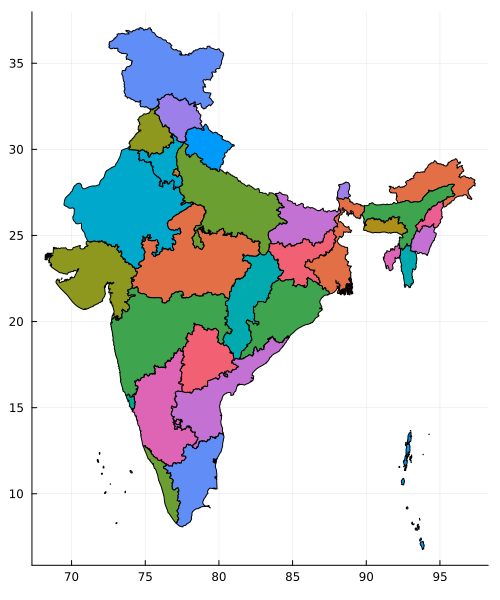

In [13]:
# @title 4.3 Plot the vector data

plot(india_states.geometry)
plot!(size=(500,600))

### 4.4 Crop the raster file using the vector file

The X and Y range will decrease after cropping.

In [14]:
india_raster = crop(raster; to = india_states.geometry)

╭─────────────────────────────╮
│ 7010×7276 Raster{Float32,2} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(68.18958531885004, 97.39375221915003, 7010) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(37.072916363249995, 6.760416120749998, 7276) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (68.18958531885004, 97.39791888585003), Y = (6.760416120749998, 37.077083029949996))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHE

### 4.5 Overlay vector file on the raster

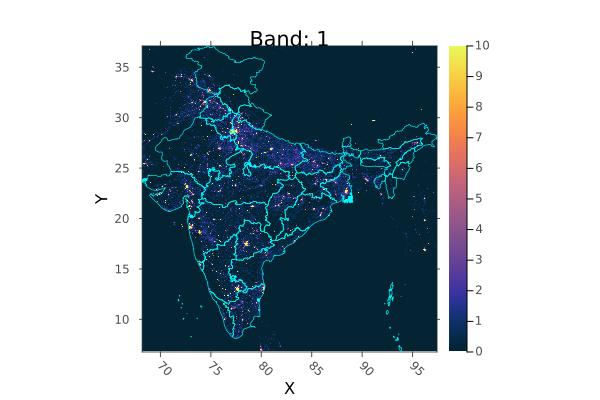

In [15]:
plot(india_raster, clims= (0, 10),  color=:thermal)
# actual values are much higher than 10. Chosen 10 just for representation.

plot!(india_states.geometry; fillalpha=0, linewidth=0.6, linecolor=:cyan)

### 4.6 Extract feature, NCT of Delhi, from the vector file

In [16]:
delhi = india_states[findfirst(region -> region == "NCT of Delhi", india_states.region)]

Feature with 2D MultiPolygon geometry and 3 properties: (:geometry, :id, :region)

### 4.7 Plot the extract feature

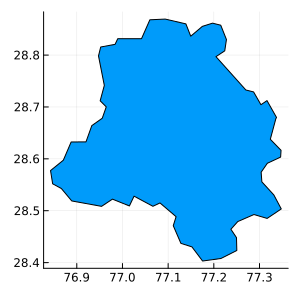

In [17]:
plot(delhi.geometry)
plot!(size=(300,300))

### 4.7 Crop the raster file to the extract feature

Once again, the X and Y range become smaller.

In [18]:
delhi_raster = crop(india_raster; to = delhi.geometry)

╭───────────────────────────╮
│ 120×111 Raster{Float32,2} │
├───────────────────────────┴──────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.84375205475004, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.864582964249998, 28.406249627249995, 111) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475004, 77.34375205875003), Y = (28.406249627249995, 28.86874963095))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WG

### 4.8 Over the shape of the extract feature on top of the raster file

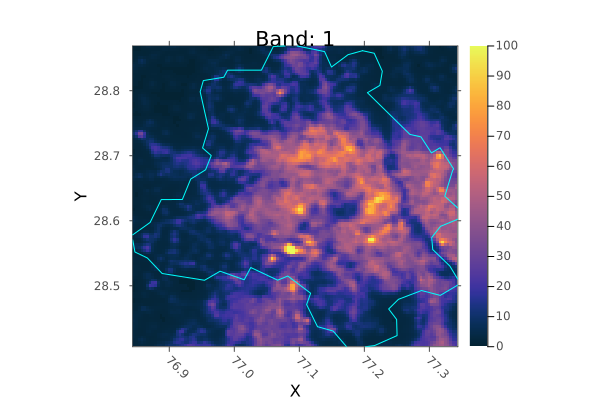

In [19]:
plot(delhi_raster, clims= (0, 100),  color=:thermal)
plot!(delhi.geometry; fillalpha=0, linewidth=1, linecolor=:cyan)

### 4.9 Remove data outside the boundary

In [20]:
delhi_masked = mask(delhi_raster; with = delhi.geometry)

╭───────────────────────────────────────────╮
│ 120×111 Raster{Union{Missing, Float32},2} │
├───────────────────────────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.84375205475004, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.864582964249998, 28.406249627249995, 111) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475004, 77.34375205875003), Y = (28.406249627249995, 28.86874963095))
  missingval: missing

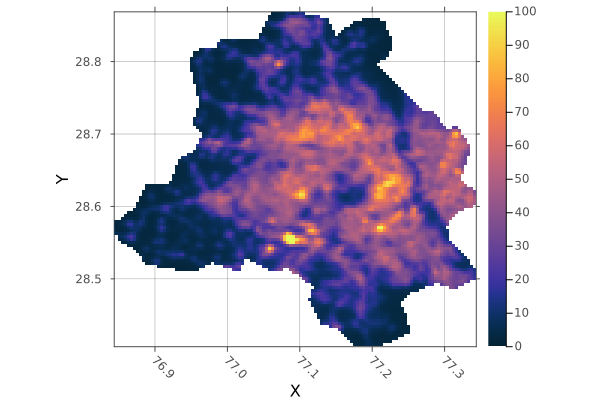

In [21]:
plot(delhi_masked, clims= (0, 100),  color=:thermal)

### 4.10 Estimate the sum of light inside the extract feature

In [28]:
# Intensity of light in Delhi
sum(skipmissing(delhi_masked))

# skipmissing creates a vector of values which are not missing.

208524.72f0

#5 Other methods of cropping and masking

In [22]:
# @title Crop using bounds

x_extent = X(Rasters.Between(76.5536049, 77.5142033))
y_extent = Y(Rasters.Between(28.2341611, 28.9333776))

delhi_bounds = x_extent, y_extent

(↓ X Between((76.5536, 77.5142)), → Y Between((28.2342, 28.9334)))

In [23]:
around_delhi = raster[delhi_bounds...]

╭───────────────────────────╮
│ 229×167 Raster{Float32,2} │
├───────────────────────────┴──────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.55625205245002, 77.50625206005004, 229) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.927082964750003, 28.235416292549996, 167) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.55625205245002, 77.51041872675005), Y = (28.235416292549996, 28.931249631450005))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID

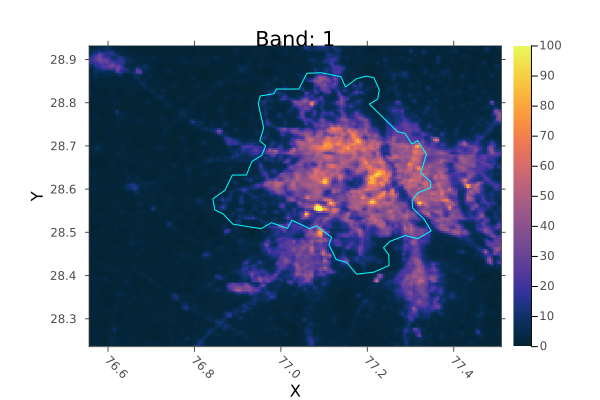

In [24]:
plot(around_delhi, clims= (0, 100),  color=:thermal)
plot!(delhi.geometry; fillalpha=0, linewidth=1, linecolor=:cyan)

In [25]:
function circular_mask(image, R, lat, long, res; buffer = 5)
    # https://www.ngdc.noaa.gov/mgg/topo/report/s6/s6A.html
    LAT =[-90.0, -89, -86, -82, -78, -74, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 74, 78, 82, 86, 89, 90]
    EW  =[0, 16.0, 64, 133, 193, 256, 318, 465, 598, 712, 804, 872, 914, 928, 914, 872, 804, 712, 598, 465, 318, 256, 193, 133, 64, 16, 0]/1000
    NS  =[931, 931.0, 931, 931, 930, 930, 930, 929, 927, 925, 924, 923, 922, 921, 922, 923, 924, 925, 927, 929, 930, 930, 930, 931, 931, 931, 931]/1000 # We divide by thousand to convert into kilometer from meter
    EW  = EW / (30 / res) # The values are for 30"
    NS  = NS / (30 / res)
    MODEL_EW = CubicSpline(LAT, EW)
    MODEL_NS = CubicSpline(LAT, NS)

    Δx = MODEL_EW[lat]
    Δy = MODEL_NS[lat]

    a = R / Δx # Δx is assumed to be constant over small distances
    b = R / Δy # Δy is assumed to be constant over small distances

    xₒ = DimensionalData.dims2indices(dims(image)[1], X(Near(long)))
    yₒ = DimensionalData.dims2indices(dims(image)[2], Y(Near(lat)))

    # add buffer to the mask

    ymin = yₒ + Int(round(b)) + buffer
    ymax = yₒ - Int(round(b)) - buffer
    xmin = xₒ - Int(round(a)) - buffer
    xmax = xₒ + Int(round(a)) + buffer

    longmin, latmin = map(getindex, dims(image), [xmin, ymin])
    longmax, latmax = map(getindex, dims(image), [xmax, ymax])

    bounds = X(Rasters.Between(longmin, longmax)), Y(Rasters.Between(latmin, latmax))
    img2 = image[bounds...]

    xₒ = DimensionalData.dims2indices(dims(img2)[1], X(Near(long)))
    yₒ = DimensionalData.dims2indices(dims(img2)[2], Y(Near(lat)))

    width_at_2(y) = Int(round(a * sqrt(abs((1 - (y-yₒ)^2 / b ^2))))) # equation of outer ellipse.
    mask = Raster(missings(Int64, size(img2)), dims(img2))

    ymin = yₒ + Int(round(b))
    ymax = yₒ - Int(round(b))

    for i in ymax:ymin
        for j in (xₒ-width_at_2(i)):(xₒ+ width_at_2(i))
            mask[j, i, 1] = 1
        end
    end
    return bounds, mask
end

circular_mask (generic function with 1 method)

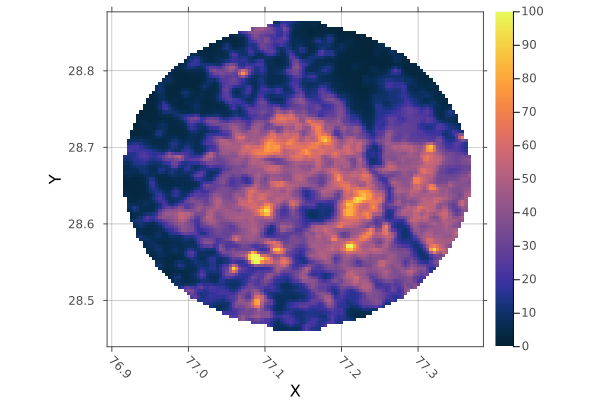

In [26]:
# @title Circular mask

ring_bounds, ring_mask = circular_mask(around_delhi, 22, 28.661030684972932, 77.14041127194707, 15)

plot(mask(around_delhi[ring_bounds...], with = ring_mask), clims= (0, 100),  color=:thermal)

Multiple masks can be used together. For example, geometry and ring.

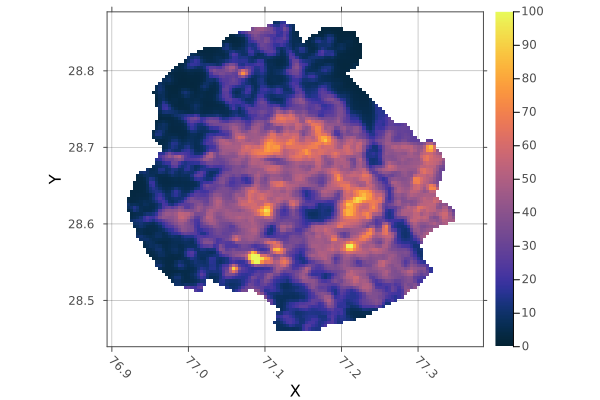

In [27]:
plot(mask(mask(around_delhi[ring_bounds...], with = ring_mask), with = delhi.geometry), clims= (0, 100),  color=:thermal)

### 6. Datacubes

Images of different years can be stacked together to form datacubes.

Datacubes are typically too large to fit in memory. So loading them requires cropping them simultaneously.

In [29]:
# @title 6.1 Define functions to load datacubes

function load_datacube(xlims = X(Rasters.Between(76.5536049, 77.5142033)), ylims = Y(Rasters.Between(28.2341611, 28.9333776)), start_year = 2017, end_year = 2019)
    lims = xlims, ylims
    raster_list = [load_raster(year)[lims...] for year in start_year:end_year]
    time = Ti(Date(start_year):Year(1):Date(end_year))
    raster_series = RasterSeries(raster_list, time)
    datacube = Rasters.combine(raster_series, time)
    return datacube
end

function load_datacube(geom, start_year = 2017, end_year = 2019)
    lims = xlims, ylims
    raster_list = [crop(load_raster(year); to = geom) for year in start_year:end_year]
    time = Ti(Date(start_year):Year(1):Date(end_year))
    raster_series = RasterSeries(raster_list, time)
    datacube = Rasters.combine(raster_series, time)
    return datacube
end


load_datacube (generic function with 5 methods)

Both `load_datacube` definitions crop the images while loading them. Hence either the limits of X and Y or the geometry is required.

### 6.2 An an example, we a datacube around Delhi.

There is an extra dimension in `around_delhi_datacube` compared to `around_delhi`, which is `T`, the time dimension.

#### 6.2.1 Crop using lims

In [30]:
around_delhi_datacube = load_datacube(X(Rasters.Between(76.5536049, 77.5142033)), Y(Rasters.Between(28.2341611, 28.9333776)), START_YEAR, END_YEAR)

╭─────────────────────────────╮
│ 229×167×3 Raster{Float32,3} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.55625205245002, 77.50625206005004, 229) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.927082964750003, 28.235416292549996, 167) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.55625205245002, 77.51041872

### 6.2.2 Crop using the geometry

In [31]:
delhi_datacube = load_datacube(delhi.geometry, START_YEAR, END_YEAR)

╭─────────────────────────────╮
│ 120×111×3 Raster{Float32,3} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.84375205475001, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.864582964249998, 28.40624962725, 111) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475001, 77.343752058750

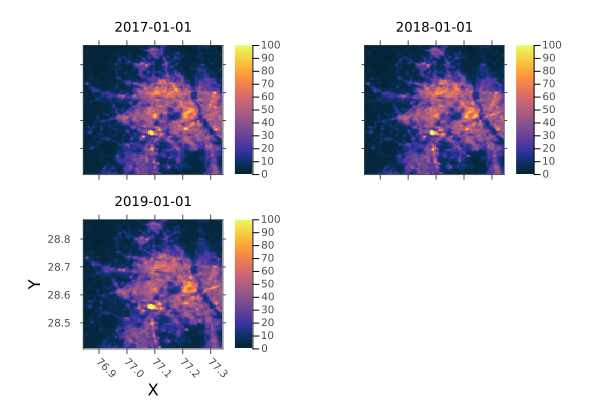

In [32]:
p = plot(delhi_datacube, clims= (0, 100),  color=:thermal)

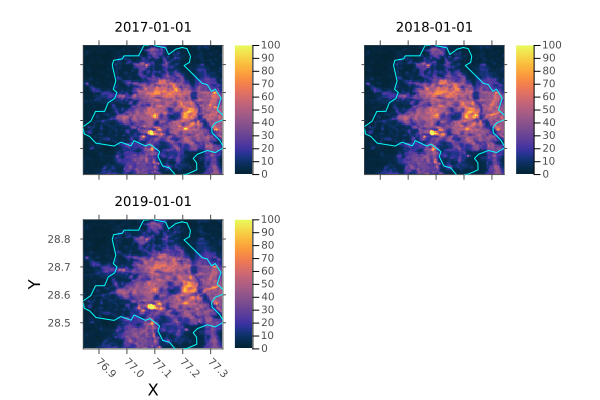

In [33]:
for i in 1:(END_YEAR - START_YEAR + 1)
    plot!(p, delhi.geometry; fillalpha=0, linewidth=1, subplot = i, linecolor=:cyan)
end
display(p)

In [34]:
delhi_datacube_mask = mask(delhi_datacube; with = delhi.geometry)

╭─────────────────────────────────────────────╮
│ 120×111×3 Raster{Union{Missing, Float32},3} │
├─────────────────────────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.84375205475001, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.864582964249998, 28.40624962725, 111) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76

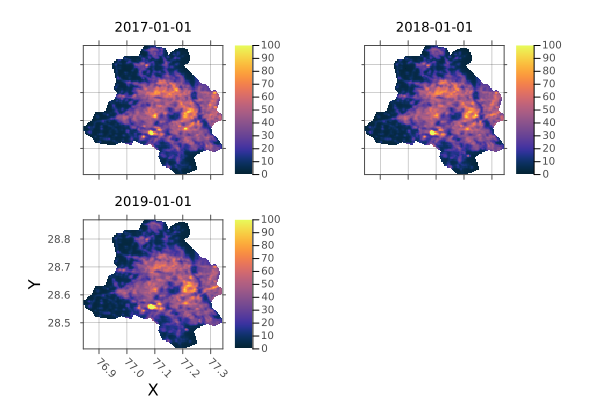

In [35]:
plot(delhi_datacube_mask, clims= (0, 100),  color=:thermal)

# References

1. Abrahams, A., Oram, C., & Lozano-Gracia, N. (2018). Deblurring DMSP nighttime lights: A new method using Gaussian filters and frequencies of illumination. *Remote Sensing of Environment, 210*, 242-258. [https://doi.org/10.1016/j.rse.2018.03.018](https://doi.org/10.1016/j.rse.2018.03.018)

2. Alesina, A., Michalopoulos, S., & Papaioannou, E. (2016). Ethnic inequality. *Journal of Political Economy, 124*(2), 428-488. [https://doi.org/10.1086/685300](https://doi.org/10.1086/685300)

3. Bresenham, J. E. (1965). Algorithm for computer control of a digital plotter. *IBM Systems journal, 4*(1), 25-30. [https://doi.org/10.1147/sj.41.0025](https://doi.org/10.1147/sj.41.0025)

4. Chen, M., Fahrner, D., Arribas-Bel, D., & Rowe, F. (2020). A reproducible notebook to acquire, process and analyse satellite imagery: Exploring long-term urban changes. *Region, 7*(2), 15-46. [https://doi.org/10.18335/region.v7i2.295](https://doi.org/10.18335/region.v7i2.295)

5. Chen, X., & Nordhaus, W. D. (2011). Using luminosity data as a proxy for economic statistics. *Proceedings of the National Academy of Sciences, 108*(21), 8589-8594. [https://doi.org/10.1073/pnas.1017031108](https://doi.org/10.1073/pnas.1017031108)

6. Donaldson, D., & Storeygard, A. (2016). The view from above: Applications of satellite data in economics. *Journal of Economic Perspectives, 30*(4), 171-98. [https://doi.org/10.1257/jep.30.4.171](https://doi.org/10.1257/jep.30.4.171)

7. Elvidge, C. D., Zhizhin, M., Ghosh, T., Hsu, F.-C., & Taneja, J. (2021). Annual time series of global VIIRS nighttime lights derived from monthly averages: 2012 to 2019. *Remote Sensing, 13*(5), 922. [https://doi.org/10.3390/rs13050922](https://doi.org/10.3390/rs13050922)


8. Elvidge, C. D., Baugh, K., Zhizhin, M., Hsu, F. C., & Ghosh, T. (2017). VIIRS night-time lights. *International Journal of Remote Sensing, 38*(21), 5860-5879. [https://doi.org/10.1080/01431161.2017.1342050](https://doi.org/10.1080/01431161.2017.1342050)

9. Elvidge, C. D., Baugh, K. E., Zhizhin, M., & Hsu, F.-C. (2013). Why VIIRS data are superior to DMSP for mapping nighttime lights. *Proceedings of the Asia-Pacific Advanced Network, 35*, 62. [https://doi.org/10.7125/APAN.35.7](https://doi.org/10.7125/APAN.35.7)

10. Ezcurra, R. (2019). Interregional inequality and civil conflict: Are spatial disparities a threat to stability and peace? *Defence and Peace Economics, 30*(7), 759-782. [https://doi.org/10.1080/10242694.2018.1446621](https://doi.org/10.1080/10242694.2018.1446621)

11. Falchetta, G. (2023). *blackmaRble: retrieve, wrangle and plot VIIRS Black Marble nighttimelight data in R*. [GitHub repository](https://github.com/giacfalk/blackmaRble)

12. Gibson, J., & Boe-Gibson, G. (2021). Which night lights data should we use in economics, and where? *Journal of Development Economics, 149*, 102602. [https://doi.org/10.1016/j.jdeveco.2020.102602](https://doi.org/10.1016/j.jdeveco.2020.102602)

13. Gibson, J. (2021). Better night lights data, for longer. *Oxford Bulletin of Economics and Statistics, 83*(3), 770-791. [https://doi.org/10.1111/obes.12417](https://doi.org/10.1111/obes.12417)

14. Gibson, J., Olivia, S., & Boe-Gibson, G. (2020). Night lights in economics: Sources and uses. *Journal of Economic Surveys, 34*(5), 955-980. [https://doi.org/10.1111/joes.12387](https://doi.org/10.1111/joes.12387)

15. Henderson, J. V., Storeygard, A., & Weil, D. N. (2012). Measuring economic growth from outer space. *American Economic Review, 102*(2), 994-1028. [https://doi.org/10.1257/aer.102.2.994](https://doi.org/10.1257/aer.102.2.994)

16. Kim, B., Gibson, J., & Boe-Gibson, G. (2024). Measurement errors in popular night lights data may bias estimated impacts of economic sanctions: Evidence from closing the Kaesong Industrial Zone. *Economic Inquiry, 62*(1), 375-389. [https://doi.org/10.1111/ecin.13183](https://doi.org/10.1111/ecin.13183)

17. Lessmann, C., & Seidel, A. (2017). Regional inequality, convergence, and its determinants -- A view from outer space. *European Economic Review, 92*, 110-132. [https://doi.org/10.1016/j.euroecorev.2016.11.009](https://doi.org/10.1016/j.euroecorev.2016.11.009)

18. Levin, N., Kyba, C. C. M., Zhang, Q., de Miguel, A. S., Román, M. O., Li, X., & Miller, S. D. (2020). Remote sensing of night lights: A review and an outlook for the future. *Remote Sensing of Environment, 237*, 111443. [https://doi.org/10.1016/j.rse.2019.111443](https://doi.org/10.1016/j.rse.2019.111443)

19. Li, X., Zhou, Y., Zhao, M., & Zhao, X. (2020). A harmonized global nighttime light dataset 1992--2018. *Scientific data, 7*(1), 1-9. [https://doi.org/10.1038/s41597-020-0510-y](https://doi.org/10.1038/s41597-020-0510-y)

20. Li, X., Zhou, Y., Zhao, M., & Zhao, X. (2021). Harmonization of DMSP and VIIRS nighttime light data from 1992-2020 at the global scale. [Figshare. Dataset.](https://doi.org/10.6084/m9.figshare.9828827.v5)

21. Mendez, C., & Santos‐Marquez, F. (2021). Regional convergence and spatial dependence across subnational regions of ASEAN: Evidence from satellite nighttime light data. *Regional Science Policy \& Practice, 13*(6), 1750-1777. [https://doi.org/10.1111/rsp3.12335](https://doi.org/10.1111/rsp3.12335)

22. Miethe, J. (2023). *Nightlightstats: R-package*. [GitHub repository](https://github.com/JakobMie/nightlightstats)

23. Mveyange, A. (2018). Measuring and Explaining Patterns of Spatial Income Inequality from Outer Space: Evidence from Africa. *World Bank Working Paper, 8484*. [https://doi.org/10.1596/1813-9450-8484](https://doi.org/10.1596/1813-9450-8484)

24. Njuguna, C. (2020). *Rnightlights: R package to extract data from satellite nightlights*. [GitHub repository](https://github.com/chrisvwn/Rnightlights)

25. Patnaik, A., Shah, A., & Thomas, S. (2023). *NighttimeLights: Package to analyse VIIRS nighttime lights*. [GitHub repository](https://github.com/xKDR/NighttimeLights.jl)

26. Raschky, P. (2020). *nighttimelights: A repository of python scripts to calculate various nighttime light statistics*. [GitHub repository](https://github.com/praschky/nighttimelights)

27. Reades, J. (2020). Teaching on jupyter. *Region, 7*(1), 21-34. [https://doi.org/10.18335/region.v7i1.282](https://doi.org/10.18335/region.v7i1.282)

28. Rodríguez-Pose, A. (2018). The revenge of the places that don't matter (and what to do about it). *Cambridge journal of regions, economy and society, 11*(1), 189-209. [https://doi.org/10.1093/cjres/rsx024](https://doi.org/10.1093/cjres/rsx024)

29. Román, M. O., Wang, Z., Sun, Q., Kalb, V., Miller, S. D., Molthan, A., ... & Stokes, E. C. (2018). NASA's Black Marble nighttime lights product suite. *Remote Sensing of Environment, 210*, 113-143. [https://doi.org/10.1016/j.rse.2018.03.017](https://doi.org/10.1016/j.rse.2018.03.017)

30. Rowe, F., Maier, G., Arribas-Bel, D., & Rey, S. J. (2020). The potential of notebooks for scientific publication: Reproducibility, and dissemination. *REGION, 7*(3), 357. [https://doi.org/10.18335/region.v7i3.357](https://doi.org/10.18335/region.v7i3.357)

31. Smits, J., & Permanyer, I. (2019). The subnational human development database. *Scientific data, 6*(1), 1-15. [https://doi.org/10.1038/sdata.2019.38](https://doi.org/10.1038/sdata.2019.38)

32. Sutton, P. C., Elvidge, C. D., Ghosh, T., & others. (2007). Estimation of gross domestic product at sub-national scales using nighttime satellite imagery. *International Journal of Ecological Economics \& Statistics, 8*(S07), 5-21.

33. Zhang, X., Gibson, J., & Deng, X. (2023). Remotely too equal: Popular DMSP night-time lights data understate spatial inequality. *Regional Science Policy \& Practice, 15*(9), 2106-2125. [https://doi.org/10.1111/rsp3.12716](https://doi.org/10.1111/rsp3.12716)

34. Zhang, X., & Gibson, J. (2022). Using multi-source nighttime lights data to proxy for county-level economic activity in China from 2012 to 2019. *Remote Sensing, 14*(5), 1282. [https://doi.org/10.3390/rs14051282](https://doi.org/10.3390/rs14051282)

35. Zheng, Q., Seto, K. C., Zhou, Y., You, S., & Weng, Q. (2023). Nighttime Light Remote Sensing for Urban Applications: Progress, Challenges, and Prospects. *ISPRS Journal of Photogrammetry and Remote Sensing, 202*, 125-141. [https://doi.org/10.1016/j.isprsjprs.2023.05.028](https://doi.org/10.1016/j.isprsjprs.2023.05.028)

36. Patnaik, A., & Mendez, C. (2024). Exploring economic activity from outer space: A Python notebook for processing and analyzing satellite nighttime lights. REGION, 11(1), 79–109. https://doi.org/10.18335/region.v11i1.493


# Appendix

## A Coordinate conversion

In [36]:
# @title A.1 Indexing rasters

raster[61706, 11112]

78.036606f0

In [37]:
raster[X(Near(77.1025)), Y(Near(28.7041))]

78.036606f0

In [38]:
# @title A.2 Converting latitude and longitude to indecies
Pkg.add(PackageSpec(name="DimensionalData", version="0.27"))

using DimensionalData

println("Column number: ", DimensionalData.dims2indices(dims(raster)[1], X(Near(77.1025))))
println("Row number: ", DimensionalData.dims2indices(dims(raster)[2], Y(Near(28.7041))))

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
⌅ [0703355e] + DimensionalData v0.27.9
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
Precompiling project...
  ✓ StructArrays → StructArraysAdaptExt


Column number: 61706
Row number: 11112


  ✓ Latexify → DataFramesExt
  2 dependencies successfully precompiled in 3 seconds. 270 already precompiled.


In [39]:
# @title A.3 Converting indecies to latitude and longitude

column = 61706
row = 11112

longitude, latitude = map(getindex, dims(raster), [column, row])

2-element Vector{Float64}:
 77.10208539015002
 28.70208296295

#B Other methods of cropping and masking

In [40]:
# @title: Crop using index

raster[61706:61806, 11112: 11212]

╭───────────────────────────╮
│ 101×101 Raster{Float32,2} │
├───────────────────────────┴──────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(77.10208539015002, 77.51875206015, 101) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.70208296295, 28.285416292949993, 101) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (77.10208539015002, 77.52291872685001), Y = (28.285416292949993, 28.706249629650003))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 8